# Introduction

In this notebook we'll make a choropleth with a timeslider. We'll use my branched version of `folium`, which contains a plugin with a class called `TimeDynamicGeoJson`.

The class needs at least two arguments to be instantiated. 

1. A string-serielized geojson containing all the features (i.e., the areas)
2. A dictionary with the following structure:

```python
styledict = {
    '0': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1}
        '2017-1-2': {'color': 'fffff0', 'opacity': 1}
        ...
        },
    ...,
    'n': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1}
        '2017-1-2': {'color': 'fffff0', 'opacity': 1}
        ...
        }
}
```

In the above dictionary, the keys are the feature-ids.

Using both color and opacity gives us the ability to simultaneously visualize two features on the choropleth. I typically use color to visualize the main feature (like, average height) and opacity to visualize how many measurements were in that group.

## Loading the features
We use `geopandas` to load a dataset containing the boundaries of all the countries in the world.

In [1]:
import geopandas as gpd

assert "naturalearth_lowres" in gpd.datasets.available
datapath = gpd.datasets.get_path("naturalearth_lowres")
gdf = gpd.read_file(datapath)

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


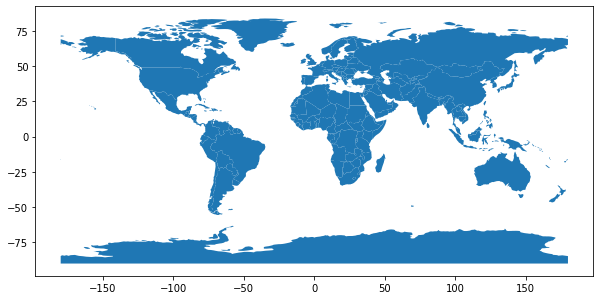

In [2]:
%matplotlib inline

ax = gdf.plot(figsize=(10, 10))

The `GeoDataFrame` contains the boundary coordinates, as well as some other data such as estimated population.

In [3]:
gdf.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


## Creating the style dictionary
Now we generate time series data for each country.  

Data for different areas might be sampled at different times, and `TimeDynamicGeoJson` can deal with that. This means that there is no need to resample the data, as long as the number of datapoints isn't too large for the browser to deal with.  

To simulate that data is sampled at different times we random sample data for `n_periods` rows of data and then pick without replacing `n_sample` of those rows. 

In [4]:
import pandas as pd

n_periods, n_sample = 48, 40

assert n_sample < n_periods

datetime_index = pd.date_range("2016-1-1", periods=n_periods, freq="M")
dt_index_epochs = datetime_index.astype(int) // 10 ** 9
dt_index = dt_index_epochs.astype("U10")

dt_index

Index(['1454198400', '1456704000', '1459382400', '1461974400', '1464652800',
       '1467244800', '1469923200', '1472601600', '1475193600', '1477872000',
       '1480464000', '1483142400', '1485820800', '1488240000', '1490918400',
       '1493510400', '1496188800', '1498780800', '1501459200', '1504137600',
       '1506729600', '1509408000', '1512000000', '1514678400', '1517356800',
       '1519776000', '1522454400', '1525046400', '1527724800', '1530316800',
       '1532995200', '1535673600', '1538265600', '1540944000', '1543536000',
       '1546214400', '1548892800', '1551312000', '1553990400', '1556582400',
       '1559260800', '1561852800', '1564531200', '1567209600', '1569801600',
       '1572480000', '1575072000', '1577750400'],
      dtype='object')

In [5]:
import numpy as np

styledata = {}

for country in gdf.index:
    df = pd.DataFrame(
        {
            "color": np.random.normal(size=n_periods),
            "opacity": np.random.normal(size=n_periods),
        },
        index=dt_index,
    )
    df = df.cumsum()
    df.sample(n_sample, replace=False).sort_index()
    styledata[country] = df

Note that the geodata and random sampled data is linked through the feature_id, which is the index of the `GeoDataFrame`.

In [6]:
gdf.loc[0]

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi

pop_est                                                  920938
continent                                               Oceania
name                                                       Fiji
iso_a3                                                      FJI
gdp_md_est                                               8374.0
geometry      (POLYGON ((180 -16.067132663642447, 180 -16.55...
Name: 0, dtype: object

In [7]:
styledata.get(0).head()

,color,opacity
1454198400,-0.383842,-0.986874
1456704000,-1.475720,-1.583585
1459382400,-3.157001,-1.664183
1461974400,-2.562194,-2.174738
1464652800,-2.311844,-2.377407


We see that we generated two series of data for each country; one for color and one for opacity. Let's plot them to see what they look like. 

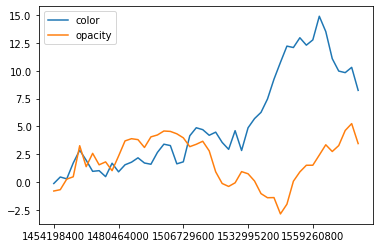

In [8]:
ax = df.plot()

Looks random alright. We want to map the column named `color` to a hex color. To do this we use a normal colormap. To create the colormap, we calculate the maximum and minimum values over all the timeseries. We also need the max/min of the `opacity` column, so that we can map that column into a range [0,1].

In [9]:
max_color, min_color, max_opacity, min_opacity = 0, 0, 0, 0

for country, data in styledata.items():
    max_color = max(max_color, data["color"].max())
    min_color = min(max_color, data["color"].min())
    max_opacity = max(max_color, data["opacity"].max())
    max_opacity = min(max_color, data["opacity"].max())

Define and apply maps: 

In [10]:
from branca.colormap import linear

cmap = linear.PuRd_09.scale(min_color, max_color)


def norm(x):
    return (x - x.min()) / (x.max() - x.min())


for country, data in styledata.items():
    data["color"] = data["color"].apply(cmap)
    data["opacity"] = norm(data["opacity"])

In [11]:
styledata.get(0).head()

,color,opacity
1454198400,#f7f4f9ff,0.705144
1456704000,#f7f4f9ff,0.597825
1459382400,#f7f4f9ff,0.583330
1461974400,#f7f4f9ff,0.491506
1464652800,#f7f4f9ff,0.455056


Finally we use `pd.DataFrame.to_dict()` to convert each dataframe into a dictionary, and place each of these in a map from country id to data. 

In [12]:
styledict = {
    str(country): data.to_dict(orient="index") for country, data in styledata.items()
}

Finally we can create the choropleth. I like to use the Stamen Toner tileset because its monochrome colors makes it neutral and clean looking.  

If the time slider above doesn't show up in the notebook, it's probably because the output is being cropped. Try loading the saved .html file in your browser for the fullscreen experience.   

In [14]:
import folium
from folium.plugins import TimeSliderChoropleth


m = folium.Map([0, 0], tiles="Stamen Toner", zoom_start=2)

g = TimeSliderChoropleth(
    gdf.to_json(),
    styledict=styledict,
).add_to(m)

m